In [1]:
import pandas as pd
import cv2
import sys
import matplotlib.pyplot as plt
import numpy as np


def rle_decode(rle_with_shape):
    """
    Decodes a Run-Length Encoding (RLE) string with shape into a binary mask.

    Parameters:
        rle_with_shape (str): RLE-encoded string with shape in the format "H,W:RLE".

    Returns:
        np.ndarray: Decoded binary mask where 255 represents the mask and 0 represents the background.
    """
    # Split the shape and RLE string
    shape_part, rle = rle_with_shape.split(":")
    height, width = map(int, shape_part.split(","))  # Extract height and width

    # Split the RLE string into a list of integers
    runs = list(map(int, rle.split()))

    # Create an empty array for the mask
    mask = np.zeros(height * width, dtype=np.uint8)

    # Iterate over the runs and set the mask values
    for start, length in zip(runs[::2], runs[1::2]):
        mask[start : start + length] = 255  # Set mask values to 255

    # Reshape the mask to the original shape
    return mask.reshape((height, width))

In [2]:
from pathlib import Path
from typing import Tuple

sys.path.append(r"D:\MSc Works\temp_matching")
# else cant load model
from temp_matching.model import CustomUnet, EncodingCombination
from temp_matching.vis import subplot_images, figure_to_array
from temp_matching.evaluator import Evaluator

model_path: Path = Path(
    r"D:\MSc Works\temp_matching\train_res\2024-09-24\best_model_state_dict.pth"
)
is_state_dict = True
input_size: Tuple[int, int] = (512, 512)
device = "cpu"
evaluator = Evaluator(
    model_path=model_path,
    is_state_dict=is_state_dict,
    device=device,
    input_size=input_size,
)

d:\MSc Works\temp_matching\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
import pandas as pd
from pathlib import Path

# Path to the CSV file
csv_path = r"D:\MSc Works\temp_matching\assets\model_results\results.csv"

# Read the raw content of the CSV file
with open(csv_path, "r") as file:
    raw_content = file.readlines()

# Replace commas inside parentheses in the bbox column
processed_content = []
for line in raw_content:
    start = line.find("(")
    end = line.find(")")
    if start != -1 and end != -1:
        bbox = line[start : end + 1]
        bbox_cleaned = bbox.replace(",", "|")  # Replace commas with '|'
        line = line.replace(bbox, bbox_cleaned)
    processed_content.append(line)

# Write the processed content back to a temporary file (optional)
with open("processed_results.csv", "w") as file:
    file.writelines(processed_content)

# Create a DataFrame from the processed content
data = [line.strip().split(",") for line in processed_content]
header = data[0]
rows = data[1:]
df = pd.DataFrame(rows, columns=header)

# Restore the original bbox format in the DataFrame
df["bbox"] = df["bbox"].str.replace("|", ",")

# Display the DataFrame
print(df.head())

                                          image_name       label  \
0  D:/MSc Works/temp_matching/assets/training_dat...         dog   
1  D:/MSc Works/temp_matching/assets/training_dat...      toilet   
2  D:/MSc Works/temp_matching/assets/training_dat...         dog   
3  D:/MSc Works/temp_matching/assets/training_dat...  motorcycle   
4  D:/MSc Works/temp_matching/assets/training_dat...         dog   

                   bbox model_iou   ann_id          model_time  \
0  (272, 200, 151, 279)     0.855     1773  0.7272758093749871   
1    (174, 0, 261, 220)     0.003  1097222  0.7272758093749871   
2  (124, 196, 372, 356)     0.885     2551  0.7272758093749871   
3    (59, 50, 501, 390)     0.922   148804  0.7272758093749871   
4  (112, 154, 367, 479)     0.964     3186  0.7272758093749871   

  model_gpu_memory model_memory sift_iou            sift_time  
0        13.129328   484.864384      1.0  0.08325220000187983  
1        13.129328   484.864384      1.0  0.07881070000075852  
2 

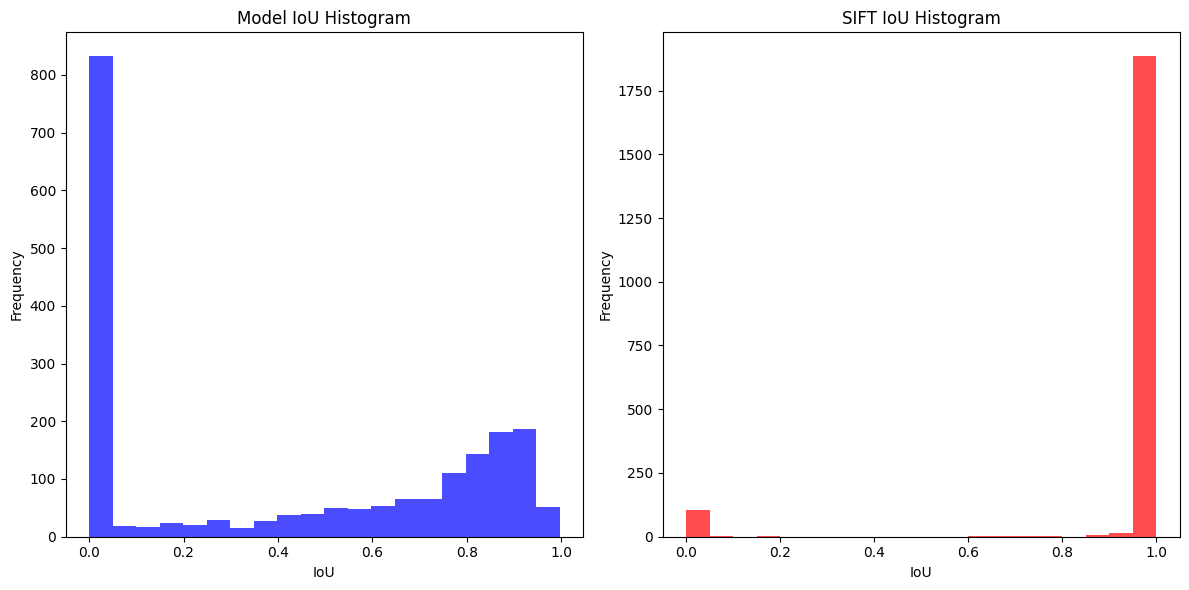

In [14]:
df.model_iou = df.model_iou.astype(float)
df.sift_iou = df.sift_iou.astype(float)
df.sift_time = df.sift_time.astype(float)
df.model_time = df.model_time.astype(float)

ndf = df.copy()
# ndf = ndf[ndf.sift_iou > 0.5]
# Plot the IoU values for the model and SIFT in subplots

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ndf.model_iou.plot.hist(ax=axes[0], bins=20, color="blue", alpha=0.7)
axes[0].set_title("Model IoU Histogram")
axes[0].set_xlabel("IoU")
axes[0].set_ylabel("Frequency")

ndf.sift_iou.plot.hist(ax=axes[1], bins=20, color="red", alpha=0.7)
axes[1].set_title("SIFT IoU Histogram")
axes[1].set_xlabel("IoU")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

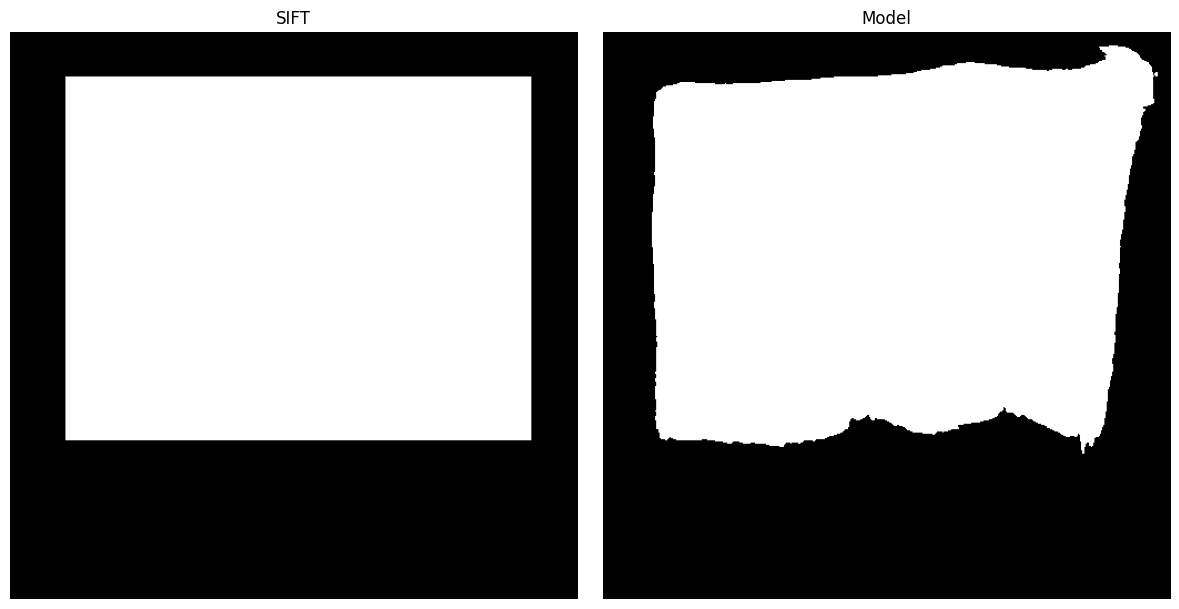

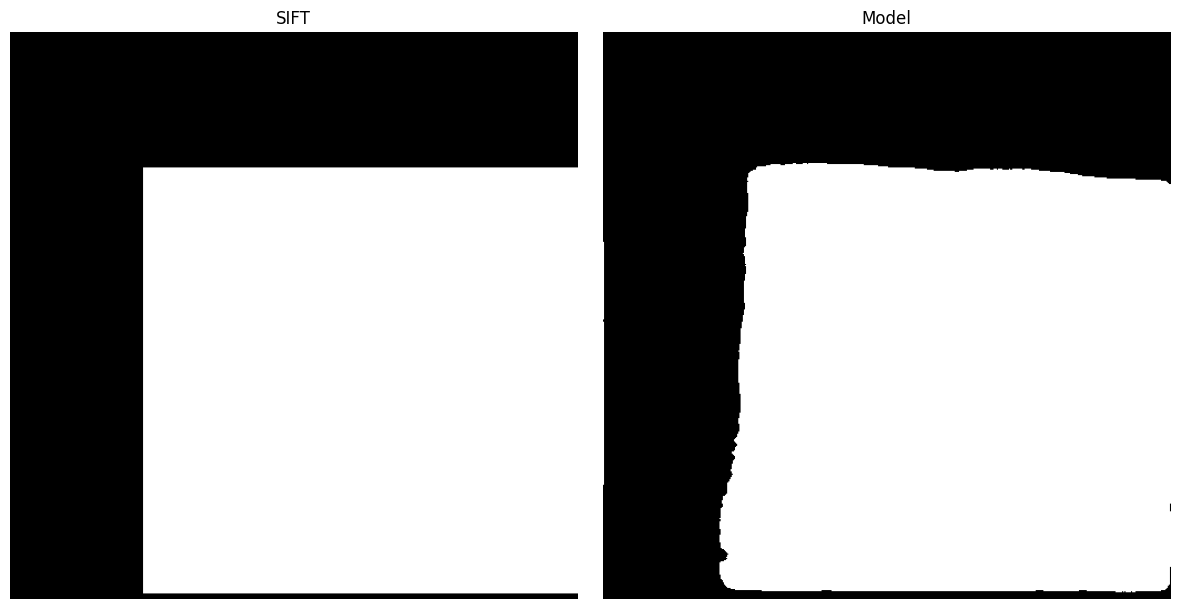

In [15]:
import numpy as np


def rle_decode(rle_with_shape):
    """
    Decodes a Run-Length Encoding (RLE) string with shape into a binary mask.

    Parameters:
        rle_with_shape (str): RLE-encoded string with shape in the format "H,W:RLE".

    Returns:
        np.ndarray: Decoded binary mask where 255 represents the mask and 0 represents the background.
    """
    with open(rle_with_shape, "r") as f:
        rle_with_shape = f.read()
    # Split the shape and RLE string
    shape_part, rle = rle_with_shape.split(":")
    height, width = map(int, shape_part.split(","))  # Extract height and width

    # Split the RLE string into a list of integers
    runs = list(map(int, rle.split()))

    # Create an empty array for the mask
    mask = np.zeros(height * width, dtype=np.uint8)

    # Iterate over the runs and set the mask values
    for start, length in zip(runs[::2], runs[1::2]):
        mask[start : start + length] = 255  # Set mask values to 255

    # Reshape the mask to the original shape
    return mask.reshape((height, width))


max = 2
itr = 0
result_dir = Path("D:/MSc Works/temp_matching/assets/model_results")
for idx, row in df.query("model_iou>0.9").iterrows():
    # print(row)
    filename = Path(row["image_name"]).stem
    sift_path = result_dir / f"{filename}_{row['ann_id']}_sift_rle.txt"
    model_path = result_dir / f"{filename}_{row['ann_id']}_model_rle.txt"
    sift = rle_decode(sift_path)
    model = rle_decode(model_path)
    sift = sift.astype(np.uint8) * 255 * 255
    model = model.astype(np.uint8) * 255 * 255

    sift = cv2.cvtColor(sift, cv2.COLOR_BGR2RGB)
    model = cv2.cvtColor(model, cv2.COLOR_BGR2RGB)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(sift)
    axes[0].set_title("SIFT")
    axes[0].axis("off")
    axes[1].imshow(model)
    axes[1].set_title("Model")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

    itr += 1
    if itr == max:
        break

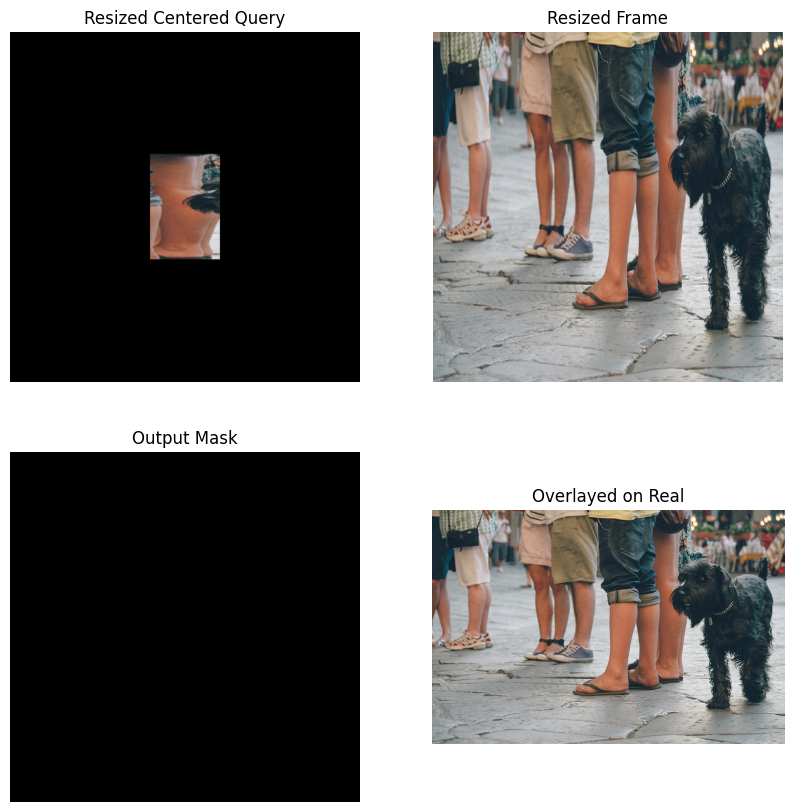

In [16]:
max_iter = 1
itr = 0
for idx, row in df.query("model_iou==0.0").iterrows():
    img_name = row["image_name"]
    bbox = row["bbox"]
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x, y, w, h = map(int, bbox[1:-1].split(","))

    query = img[y : y + h, x : x + w]
    query = cv2.resize(query, (128, 128))
    evaluator.set_query(query, img)
    output = evaluator.fast_predict(img)

    output = evaluator.post_process(output)
    overlayed = evaluator.overlay_mask(img, output)
    fig = subplot_images(
        [
            evaluator.query,
            evaluator.image,
            cv2.cvtColor(output, cv2.COLOR_GRAY2BGR) * 255,
            overlayed,
        ],
        order=(2, -1),
        titles=[
            "Resized Centered Query",
            "Resized Frame",
            "Output Mask",
            "Overlayed on Real",
        ],
        show=False,
    )

    itr += 1

    if itr == max_iter:
        break

In [10]:
evaluator.input_size

(512, 512)

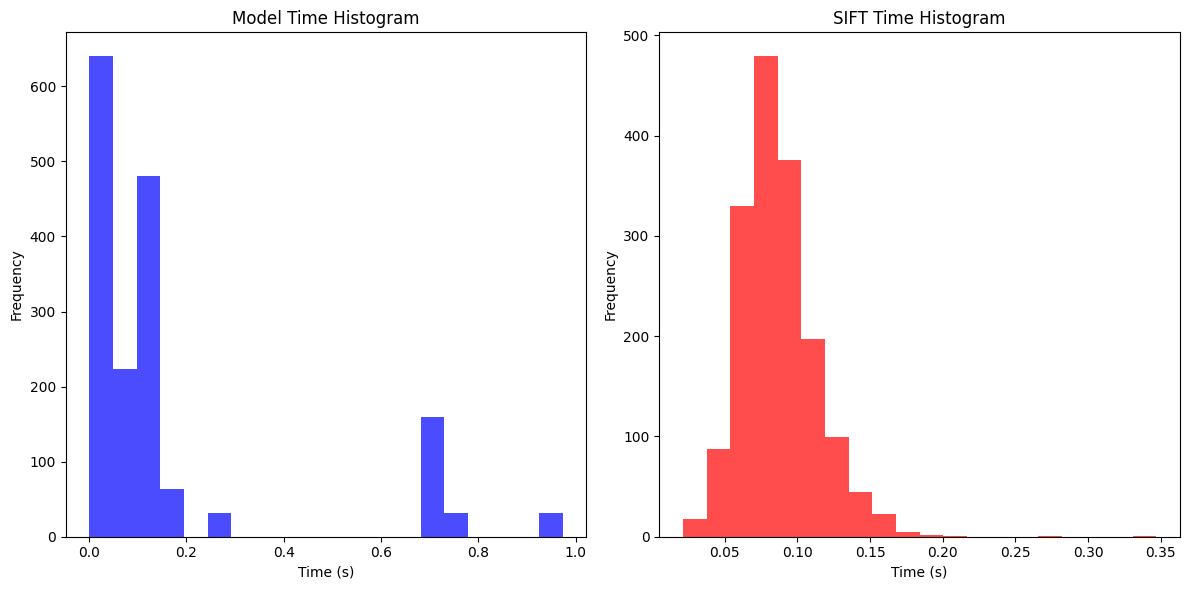

In [7]:
# Plot the time taken by the model and SIFT in subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ndf.model_time.plot.hist(ax=axes[0], bins=20, color="blue", alpha=0.7)
axes[0].set_title("Model Time Histogram")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Frequency")

ndf.sift_time.plot.hist(ax=axes[1], bins=20, color="red", alpha=0.7)
axes[1].set_title("SIFT Time Histogram")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [8]:
# count the number of rows with model_iou > 0.5 and sift_iou > 0.5
model_iou_count = (df.model_iou > 0.9).sum()
sift_iou_count = (df.sift_iou > 0.9).sum()

print(f"Model IoU > 0.5: {model_iou_count}")
print(f"SIFT IoU > 0.5: {sift_iou_count}")

Model IoU > 0.5: 167
SIFT IoU > 0.5: 1572
